In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Flatten, Input, Dense, Lambda, Concatenate
from keras.optimizers import SGD, Adam
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
epochs=5
batch_size = 32

intermediate_dim=512
latent_dim = 2

# Load data

In [3]:
# Must be same dimension as lentent_dim
target_mean = [0, 0]
target_var = [0, 0]

In [4]:
num_class = 10
input_shape = [28 * 28]

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, *input_shape).astype('float32') / 255
x_test = x_test.reshape(-1, *input_shape).astype('float32') / 255

y_kl_train = np.zeros((60000, 4)) + [*target_mean, *target_var]
y_kl_test = np.zeros((10000, 4)) + [*target_mean, *target_var]

print(f"x:\t{x_train.shape}\ny_kl:\t{y_kl_train.shape}")

x:	(60000, 784)
y_kl:	(60000, 4)


# Create model

### 1. Build encoder

In [5]:
def sampling(args):
    """Sample z wrt mean and log var from network output"""
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [6]:
x = Input(shape=input_shape, name="image_input")

encoding = Dense(intermediate_dim, activation='relu') (x)

mean = Dense(latent_dim, name="z_mean") (encoding)
log_var = Dense(latent_dim, name="z_log_var") (encoding)
encoding = Lambda(sampling, name="encoded") ([mean, log_var])

encoder = Model(inputs=x, outputs=[mean, log_var, encoding], name='encoder')

### 2. Build decoder

In [7]:
decoder = Sequential([
    Dense(intermediate_dim, activation='relu'),
    Dense(784, activation='sigmoid', name="decoded")
], name="decoder")

### 3. Build VAE from decoder and encoder

In [8]:
# Run input through encoder
x_encoded, x_mean, x_log_var = encoder(x)

# Reconstruct image from sampled data
x_reconstructed = decoder(x_encoded)

# Join mean and log var to feed to KL divergence
x_mean_log_var = Concatenate(name="mean_and_log_var") ([x_mean, x_log_var])

vae = Model(x, [x_reconstructed, x_mean_log_var])

In [9]:
plot_model(vae, show_shapes=True)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403972      image_input[0][0]                
__________________________________________________________________________________________________
decoder (Sequential)            (None, 784)          403728      encoder[1][0]                    
__________________________________________________________________________________________________
mean_and_log_var (Concatenate)  (None, 4)            0           encoder[1][1]                    
                                                                 encoder[1][2]                    
Total para

# Train

In [10]:
def kl_divergence(y_true, y_pred):
    # Separate mean and log var from concatenated output
    y_mean, y_log_sigma = y_true[:, :2], y_true[:, 2:]
    z_mean, z_log_sigma = y_pred[:, :2], y_pred[:, 2:]
    
    kl = 1 + z_log_sigma - y_log_sigma - K.square(z_mean - y_mean) / K.exp(y_log_sigma) - K.exp(z_log_sigma - y_log_sigma)
    kl = -0.5 * K.sum(kl, axis=-1)
    
    return kl

In [11]:
opt = Adam(lr=1e-4)
vae.compile(optimizer=opt,
            loss=[binary_crossentropy, kl_divergence],
            loss_weights=[784, 1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 33s 556us/step - loss: 209.5029 - decoder_loss: 0.2586 - mean_and_log_var_loss: 6.7971 - val_loss: 186.1961 - val_decoder_loss: 0.2326 - val_mean_and_log_var_loss: 3.8079
Epoch 2/5
60000/60000 [==============================] - 33s 548us/step - loss: 178.0533 - decoder_loss: 0.2237 - mean_and_log_var_loss: 2.7039 - val_loss: 170.6507 - val_decoder_loss: 0.2149 - val_mean_and_log_var_loss: 2.1412
Epoch 3/5
60000/60000 [==============================] - 33s 550us/step - loss: 168.3180 - decoder_loss: 0.2122 - mean_and_log_var_loss: 1.9913 - val_loss: 166.4946 - val_decoder_loss: 0.2101 - val_mean_and_log_var_loss: 1.7883
Epoch 4/5
60000/60000 [==============================] - 33s 554us/step - loss: 165.1020 - decoder_loss: 0.2084 - mean_and_log_var_loss: 1.7529 - val_loss: 164.2621 - val_decoder_loss: 0.2074 - val_mean_and_log_var_loss: 1.6263
Epoch 5/5
60000/60000 [===============

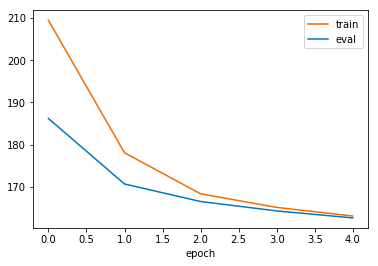

In [12]:
hist = vae.fit(x=x_train,
               y=[x_train, y_kl_train],
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(x_test, [x_test, y_kl_test]))

plt.plot(hist.history['loss'], '#EF6C00', label='train')
plt.plot(hist.history['val_loss'], '#0077BB', label='eval')
plt.xlabel('epoch')
plt.legend()

# Visualization

### Plot latent dim

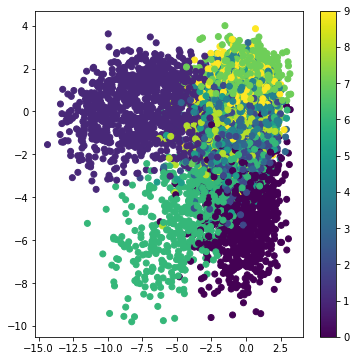

In [13]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[-1]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
_ = plt.colorbar()

### Explore output space

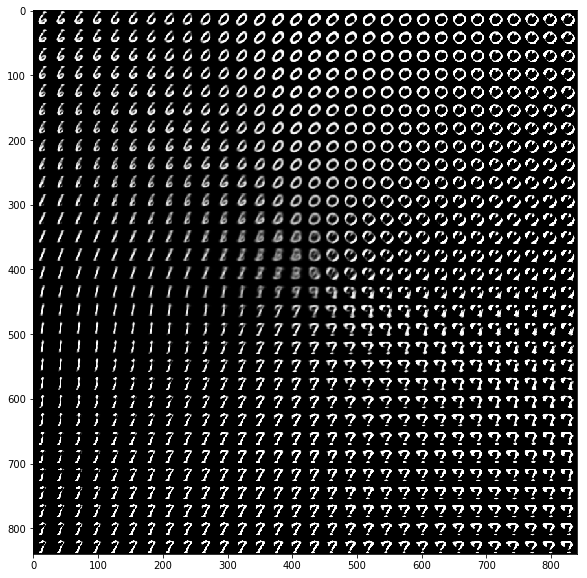

In [14]:
# display a 2D manifold of the digits
n = 30  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
boundary = 15
grid_x = np.linspace(-boundary, boundary, n)
grid_y = np.linspace(-boundary, boundary, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
_ = plt.imshow(figure, cmap="gray")

### Generate numbers

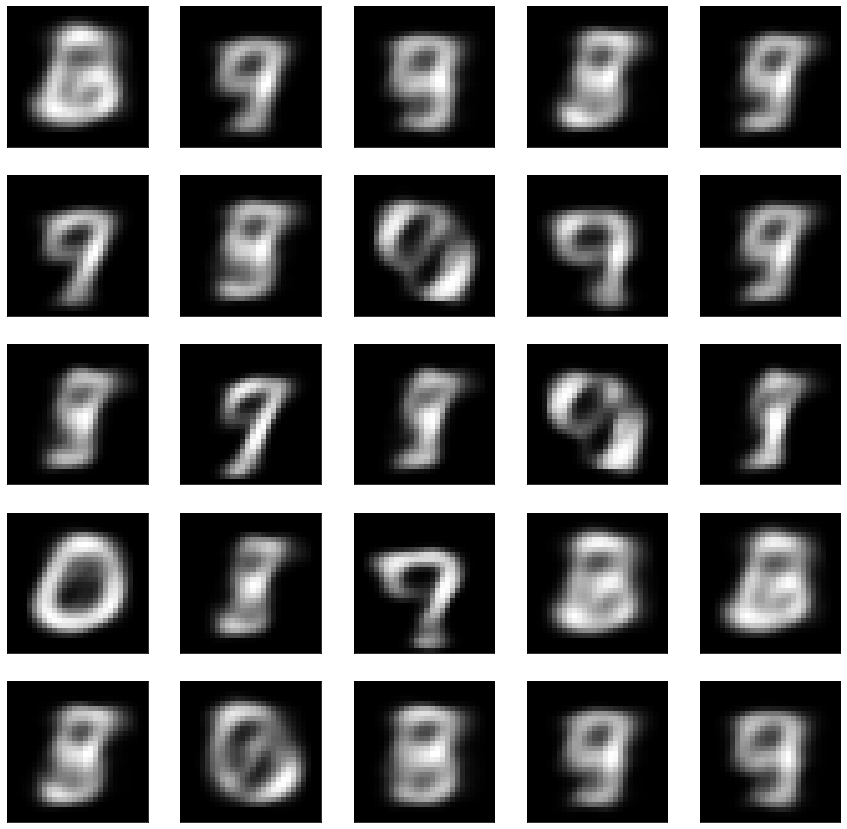

In [15]:
plt.figure(figsize=(15, 15))
n_lignes = 5
n_col = 5

sample_z = np.random.normal(size=(n_lignes*n_col, latent_dim,))
output = decoder.predict(sample_z)

for i, img in enumerate(output):
    ax = plt.subplot(n_col, n_lignes, i + 1)
    plt.imshow(img.reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)